In [1]:
import os
import pydicom
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist
from scipy.ndimage import gaussian_filter1d
from scipy.signal import deconvolve
from scipy.signal import convolve
from scipy.special import gamma
from scipy.optimize import minimize
import pandas as pd

In [2]:
dcm_path = 'SRS00013/IMG00001.DCM'
folder_path = 'SRS00013/'  # Update this to the path of your DICOM folder

aif_pixel = (171,110,9)
# vof_pixel = (171,108,13)
vof_pixel = (124,195,17)

xyztuples = [  
    (171,110,9),
    
    # (173,103,13),
    # (173,104,13),
    (171,108,13),

    (124,195,17)
    ]

# Define the hematocrit correction factor kH
Ha = 0.45  # Typical arterial hematocrit
Ht = 0.25  # Typical tissue hematocrit        
kH = (1 - Ha) / (1 - Ht)

# Initialize a list to hold your image data
image_data = []
acquisition_times = []
image_positions = []
acquisition_numbers =[]
instance_numbers = []

dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.DCM')]

Benchmark

RT: 1590
TE: 32
flip angle: 90

In [3]:
def time_to_seconds(t):
    """Converts a time string in HHMMSS.fff format to seconds."""
    hours, minutes, seconds = int(t[:2]), int(t[2:4]), float(t[4:])
    return 3600 * hours + 60 * minutes + seconds

for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    
    # Preprocess the image as necessary. This is just a placeholder for any actual preprocessing you need to do.
    # For example: image = preprocess(ds.pixel_array)
    image_data.append(equalize_adapthist(gaussian(ds.pixel_array, sigma=1)))
    # image_data.append(ds.pixel_array)
    
    # Extract acquisition time; note that you'll need to adjust 'AcquisitionTime' based on your DICOM files' metadata structure
    acquisition_times.append(time_to_seconds(ds.AcquisitionTime))
    image_positions.append(ds.ImagePositionPatient)
    
    acquisition_numbers.append(ds.AcquisitionNumber)
    instance_numbers.append(ds.InstanceNumber)
    
image_data = np.array(image_data)
image_positions = np.array(image_positions)
acquisition_times = np.array(acquisition_times)

# Assuming these are your original lists:
# image_data = [np.array(...) for _ in range(1000)]  # Each a 256x256 numpy array
# image_position = [np.array(...) for _ in range(1000)]  # Each a 1x3 numpy array
# acquisition_time = [np.random.rand() for _ in range(1000)]  # Each a random float

# Step 1: Combine the lists into a single list of tuples
combined = list(zip(image_data, image_positions, acquisition_times, acquisition_numbers, instance_numbers))

# combined.sort(key=lambda x: x[-1])

combined.sort(key=lambda x: x[2])
# Step 2: Sort the combined list by the image_position (assuming it's the second element of the tuple)
combined.sort(key=lambda x: x[1][1])  # Adjust the lambda function if sorting criteria are different

# Step 3: Separate the combined list back into three lists
image_data_sorted, image_position_sorted, acquisition_time_sorted, acquisition_numbers_sorted, instance_numbers_sorted = zip(*combined)

# If you need the results to be in list format instead of tuples (especially for the image data), you can convert them
# image_data_sorted = list(equalize_adapthist(gaussian(np.array(image_data_sorted) , sigma=1)))
image_data_sorted = list(image_data_sorted)
image_position_sorted = list(image_position_sorted)
acquisition_time_sorted = list(acquisition_time_sorted)
acquisition_numbers_sorted = list(acquisition_numbers_sorted)
instance_numbers_sorted = list(instance_numbers_sorted)

image_data_sorted = np.array(image_data_sorted)

def intensity_to_concentration(intensity, baseline=None):
    
    if baseline is None:
        baseline = np.average(intensity[6:8]) #TODO: Baseline modeling
    
    baseline = baseline + np.min(baseline)
    
    # Placeholder values for demonstration
    te = 32  # Echo time in milliseconds (ms)
    s0 = baseline  # Baseline signal intensity before contrast injection
    st = intensity  # Signal intensity at different times after contrast injection

    # Calculating contrast agent concentration using the provided formula
    # ct = (1/te) * np.log(st/s0)
    ct = 1/st
    return ct

def plt_point(x,y,z,view=False):
    times = acquisition_time_sorted[50*(z-1):50*z]-acquisition_time_sorted[50*(z-1)]
    concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y])
    if view:
        print("InstanceNumbers: ")
        print(instance_numbers_sorted[50*(z-1):50*z])
        print("AcquisitionNumbers: ")
        print(acquisition_numbers_sorted[50*(z-1):50*z])
        print("unique image_positions: ")
        print(np.unique(image_position_sorted[50*(z-1):50*z]))
    
    # Assuming 'concentration' and 'time_points' are your data arrays
    plt.figure(figsize=(10, 6))
    plt.plot(times, concentrations, '-o', label='Concentration over Time')
    plt.title(f'Concentration vs. Time at <{x},{y},{z}>*\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Interactive visualization of 3D data over time
def explore_3dimage_time(i=0,z=0,x=0,y=0,vis=False,aif=False):
    if vis:
        i = (z-1)*50+i
        plt.figure(figsize=(10, 5),facecolor='k')
        plt.imshow(image_data_sorted[i, :, :], cmap='gray')  # Adjust the 15 here to show different slices
        plt.title(f'#: {instance_numbers_sorted[i]} Position: {image_position_sorted[i]} \n T#: {acquisition_numbers_sorted[i]} Time: {acquisition_time_sorted[i]}',color='blue')
        plt.axis('off')
        plt.scatter(x, y, color='red', s=10)  # Highlight the point
        plt.tight_layout()
        plt.show()
    if aif: 
        plt_point(x,y,z)
        
def smooth_data_gaussian(data, sigma=1):
    """
    Smooths the data using a Gaussian filter.

    :param data: The input data to smooth.
    :param sigma: The standard deviation for the Gaussian kernel.
    :return: The smoothed data.
    """
    return gaussian_filter1d(data, sigma)

def plt_pointss(xyztuples=None, view=False, smooth=False, legend_on=False):
    if xyztuples is None:
        xyztuples = [(0, 0, 0)]
    plt.figure(figsize=(5, 6))
    
    for i, (x, y, z) in enumerate(xyztuples):
        times = acquisition_time_sorted[50*(z-1):50*z] - acquisition_time_sorted[50*(z-1)]
        concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y])
        
        # Smooth the concentration data using Gaussian filter
        if smooth:
            smoothed_concentrations = smooth_data_gaussian(concentrations)
        else:
            smoothed_concentrations = concentrations.copy()

        if view:
            print(f"Data for {x},{y},{z}")
            print("InstanceNumbers: ")
            print(instance_numbers_sorted[50*(z-1):50*z])
            print("AcquisitionNumbers: ")
            print(acquisition_numbers_sorted[50*(z-1):50*z])
            print("unique image_positions: ")
            print(np.unique(image_position_sorted[50*(z-1):50*z]))
            print()  # Print a newline for readability
        
        plt.plot(times, smoothed_concentrations, '-o', label=f'<{x},{y},{z}>')
    
    plt.title('Smoothed Concentration vs. Time for Multiple Points\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    if legend_on:    
        plt.legend()
    plt.grid(True)
    plt.show()

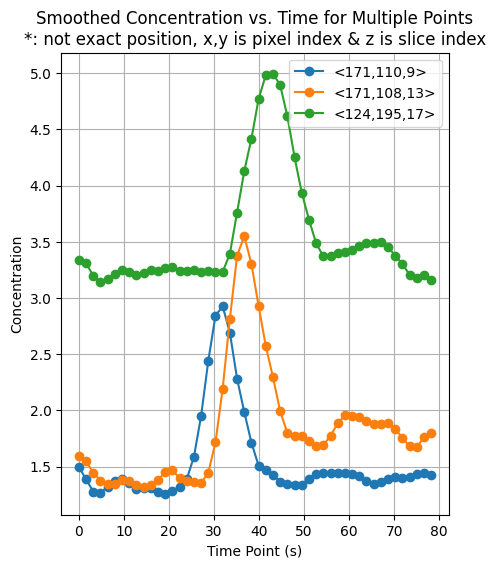

In [4]:
plt_pointss(xyztuples,smooth=True, legend_on=True)

R(t): [2.08688136]
Tissue blood flow (F): (50,)


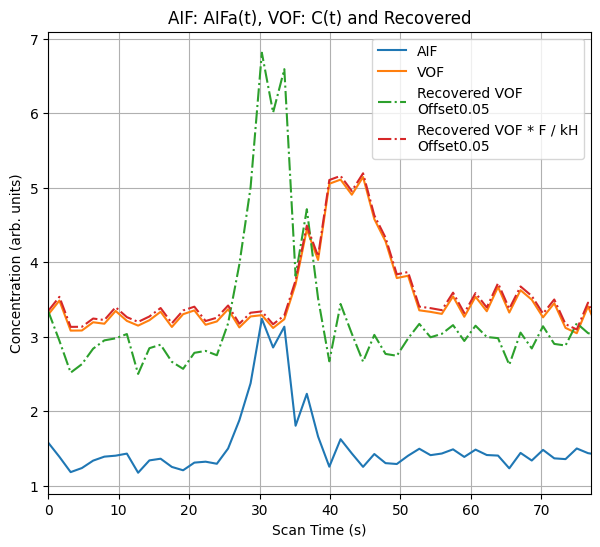

In [5]:
def read_point4time(x,y,z):
    """Read time points for a given slice."""
    return acquisition_time_sorted[50*(z-1):50*z] - acquisition_time_sorted[50*(z-1)]

def read_point4concentration(x, y, z):
    """Read concentration data for a given point."""
    return intensity_to_concentration(image_data_sorted[50*(z-1):50*z, x, y])  

def calculate_r_f(aif_concentration, tissue_concentration):
    """
    Calculate R(t) and F for multiple tissue points.
    
    :param aif_concentration: Tuple containing the concentration of the AIF pixel (x, y, z).
    :param tissue_concentration: Tuple containing the concentration of the tissue pixel (x, y, z).
    :return: A dictionary with tissue point coordinates as keys and (R_t, F) tuples as values.
    """
    # Define the hematocrit correction factor kH
    Ha = 0.45  # Typical arterial hematocrit
    Ht = 0.25  # Typical tissue hematocrit        
    kH = (1 - Ha) / (1 - Ht)
        
    # Apply deconvolution
    R_t, remainder = deconvolve(tissue_concentration, aif_concentration)
    F = (1 + remainder / convolve(aif_concentration, R_t)) *kH
            
    return R_t, F

# Example usage
# aif_pixel = (169, 99, 9)  # AIF pixel coordinates
# vof_pixel = (173, 101,10)

R_t, F_t= calculate_r_f(read_point4concentration(*aif_pixel),read_point4concentration(*vof_pixel))

print(f"R(t):", R_t)
print(f"Tissue blood flow (F):", F_t.shape)

time = read_point4time(*vof_pixel)

AIFa_t = read_point4concentration(*aif_pixel)
C_t = read_point4concentration(*vof_pixel)
Cr = np.convolve(AIFa_t, R_t, mode='full')

plt.figure(figsize=(7, 6))
plt.plot(time, AIFa_t, label='AIF')
plt.plot(time, C_t, label='VOF')
# plt.hlines(R_t, xmin=0,xmax=max(time),label='R(t)', linestyle='--')
plt.plot(time, Cr + 0.05, label='Recovered VOF\nOffset0.05', linestyle='-.')
plt.plot(time, Cr * F_t / kH + 0.05, label='Recovered VOF * F / kH\nOffset0.05', linestyle='-.')
plt.xlabel('Scan Time (s)')
plt.ylabel('Concentration (arb. units)')
plt.legend()
plt.title('AIF: AIFa(t), VOF: C(t) and Recovered')
plt.grid(True)

plt.xlim(0,77)

# plt.savefig('AIF_VOF_Recover.png', facecolor='black', transparent=True)
plt.show()

In [6]:
# Example points to draw
aif_pixels = [aif_pixel]
vof_pixels = [vof_pixel]
# Function to draw the slices with points
def draw_slices_with_points(i=0):
    fig, axes = plt.subplots(4, 5, figsize=(10, 8), facecolor='black') # Adjust the subplot grid if needed
    axes = axes.flatten()
    
    for z in range(1, 21): # Assuming you have 20 slices
        ax = axes[z-1]
        img_index = (z-1) * 50 + i # Calculate the index of the image to show
        ax.imshow(image_data_sorted[img_index, :, :], cmap='gray')
        
        # Draw the specified points for the current slice
        for x, y, slice_z in aif_pixels:
            if slice_z == z: # Check if the point belongs to the current slice
                ax.scatter(x, y, color='red', s=10)
        for x, y, slice_z in vof_pixels:
            if slice_z == z: # Check if the point belongs to the current slice
                ax.scatter(x, y, color='blue', s=10)
        
        # ax.set_title(f'Slice #{z}')
        ax.axis('off')
    
    plt.tight_layout()
    # plt.savefig('AIF_Tissue_Points.png', facecolor='black', transparent=True)
    plt.show()
    
# Create a slider to interact with the function
interact(draw_slices_with_points, i=IntSlider(min=0, max=49, step=1, value=20))

interactive(children=(IntSlider(value=20, description='i', max=49), Output()), _dom_classes=('widget-interact'…

<function __main__.draw_slices_with_points(i=0)>

In [7]:
# Define the gamma variate function (GVF) according to your parameters
def gamma_variate_function(t, A1, alpha1, sigma1, t1):
    return (1 / A1) * ((t - t1) ** alpha1) * np.exp(-(t - t1) / sigma1) if t >= t1 else 0

# Estimated parameters (example values, you need to calculate these from your data)
td = 5  # Estimated from your dataa
alpha1 = 0  # Estimated from your dataa
beta1 = 0.12    # Given
t1 = td*(1-beta1)
sigma1 = t1 * beta1 / (1-beta1)
A1 = sigma1**(1+alpha1) * gamma(1+alpha1)   # 

time = read_point4time(*vof_pixel)

# Apply the GVF to your time vector
ha_t = []

for t in time:
    ha_t.append(gamma_variate_function(t, A1,alpha1,sigma1,t1))

# Your AIFa(t) data (replace this with your actual data)
AIFa_t = AIFa_t  # Example data

# Convolve AIFa(t) with ha(t) to get AIFt(t)
AIFt_t = convolve(AIFa_t, ha_t)

# Since the convolution extends beyond the original signal length, you may want to trim it
AIFt_t = AIFt_t[:len(time)]

# Now AIFt_t contains the arterial input function at the tissue of interest

Re(t): [2.94323964]
Tissue blood flow (Ft): (50,)


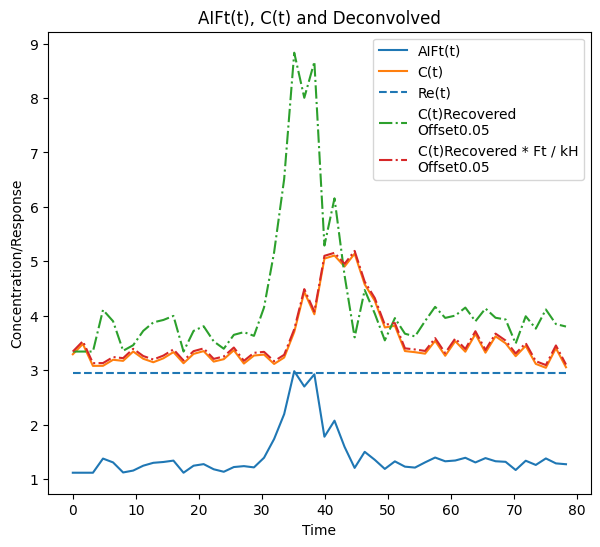

In [8]:
newAIFt_t = []
low = max(AIFt_t)
for point in AIFt_t:
    if point != 0: low = min(point, low)
    
for point in AIFt_t:
    if point == 0: newAIFt_t.append(low)
    else: newAIFt_t.append(point)

Re_t, Ft_t= calculate_r_f(newAIFt_t, read_point4concentration(*vof_pixel))

print(f"Re(t):", Re_t)
print(f"Tissue blood flow (Ft):", Ft_t.shape)

time = read_point4time(*vof_pixel)

C_t = read_point4concentration(*vof_pixel)
Cr = np.convolve(newAIFt_t, Re_t, mode='full') 

plt.figure(figsize=(7, 6))
plt.plot(time, newAIFt_t, label='AIFt(t)')
plt.plot(time, C_t, label='C(t)')
plt.hlines(Re_t, xmin=0,xmax=max(time),label='Re(t)', linestyle='--')
plt.plot(time, Cr + 0.05, label='C(t)Recovered\nOffset0.05', linestyle='-.')
plt.plot(time, Cr * Ft_t / kH + 0.05, label='C(t)Recovered * Ft / kH\nOffset0.05', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Concentration/Response')
plt.legend()
plt.title('AIFt(t), C(t) and Deconvolved')
plt.show()